<a href="https://colab.research.google.com/github/Garima27dec/Emotion-Detection-with-Multiple-Data-Streams/blob/main/Models_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing and installing Libraries**

In [1]:
!pip install -U tensorflow-text==2.12.0
!pip3 install opencv-python
!pip install pydub
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 53.5 MB/s eta 0:00:00


In [2]:
import tensorflow_hub as hub
import tensorflow_text as text
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM,Dropout,TimeDistributed, Flatten, Bidirectional, Input
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import re
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import glob
import statistics
from scipy.ndimage import zoom
from os import path
from pydub import AudioSegment
import librosa
import IPython
from IPython.display import Audio, Image
import speech_recognition

##**Connecting to Storage - to import saved models**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Loading Face, Speech, Text Emotion Recognition Models**

In [4]:
from keras.models import model_from_json
with open('/content/drive/MyDrive/FER/model_3.json','r') as f:
    json = f.read()
model_fer = model_from_json(json)

model_fer.load_weights('/content/drive/MyDrive/FER/model_3.h5')
print("Loaded FER model from disk")

Loaded FER model from disk


In [36]:
from keras.models import load_model
model_ser = load_model('/content/drive/MyDrive/SER/[CNN-LSTM]M.h5')

model_ser.load_weights('/content/drive/MyDrive/SER/[CNN-LSTM]W.h5')
print("Loaded SER model from disk")

Loaded SER model from disk


In [4]:
model_ter = tf.keras.models.load_model(('/content/drive/MyDrive/TEXT/BERT_M.h5'), custom_objects={'KerasLayer':hub.KerasLayer})
model_ter.load_weights('/content/drive/MyDrive/TEXT/BERT_W.h5')
print("Loaded Text_ER model from disk")

Loaded Text_ER model from disk


In [6]:
import os

# directory/folder path
dir_path = '/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/'

test_data = os.listdir(dir_path)
print(test_data)


['dia15_utt4.mp4', 'dia15_utt7.mp4', 'dia16_utt0.mp4', 'dia16_utt1.mp4', 'dia16_utt2.mp4', 'dia16_utt3.mp4', 'dia16_utt4.mp4', 'dia16_utt5.mp4', 'dia16_utt6.mp4', 'dia16_utt7.mp4', 'dia16_utt10.mp4', 'dia16_utt11.mp4', 'dia16_utt12.mp4', 'dia16_utt13.mp4', 'dia16_utt14.mp4', 'dia16_utt15.mp4', 'dia16_utt16.mp4', 'dia16_utt17.mp4', 'dia16_utt18.mp4', 'dia17_utt0.mp4', 'dia17_utt1.mp4', 'dia17_utt4.mp4', 'dia18_utt4.mp4', 'dia18_utt7.mp4', 'dia18_utt8.mp4', 'dia18_utt11.mp4', 'dia19_utt0.mp4', 'dia19_utt3.mp4', 'dia19_utt4.mp4', 'dia19_utt5.mp4', 'dia19_utt8.mp4', 'dia19_utt9.mp4', 'dia19_utt14.mp4', 'dia19_utt15.mp4', 'dia19_utt16.mp4', 'dia19_utt17.mp4', 'dia19_utt18.mp4', 'dia19_utt19.mp4', 'dia19_utt20.mp4', 'dia19_utt21.mp4', 'dia19_utt22.mp4', 'dia20_utt0.mp4', 'dia20_utt1.mp4', 'dia20_utt2.mp4', 'dia20_utt3.mp4', 'dia20_utt6.mp4', 'dia20_utt7.mp4', 'dia21_utt0.mp4', 'dia21_utt1.mp4', 'dia21_utt2.mp4', 'dia21_utt3.mp4', 'dia21_utt4.mp4', 'dia21_utt5.mp4', 'dia21_utt6.mp4', 'dia22_u

##**Defining functions for Data Pre-processing**

In [8]:
shape_x = 48
shape_y = 48

In [38]:
def detect_face(frame):

    #Cascade classifier pre-trained model
    cascPath = '/content/drive/MyDrive/FER/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []

    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])

    return gray, detected_faces, coord

In [10]:
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]

    new_face = []

    for det in detected_face :

        x, y, w, h = det


        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]


        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)

        new_face.append(new_extracted_face)

    return new_face

In [29]:
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/content/drive/MyDrive/FER/Results/"+"image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames


In [12]:
def get_label_fer(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

In [104]:
def get_label_ser(argument):
    labels = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Angry', 4:'Fear' , 5:'Disgust', 6:'Surprise'}
    return(labels.get(argument, "Invalid emotion"))

In [105]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):

    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2

    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)

    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

    return mel_spect

In [106]:
# Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

In [5]:
def text_prediction(test_string):
  class_prob = model_ter.predict(test_string, batch_size=1)[0]
  if np.argmax(class_prob)==0:
    return("Angry")
  elif np.argmax(class_prob)==1:
    return("Disgust")
  elif np.argmax(class_prob)==2:
    return("Fear")
  elif np.argmax(class_prob)==3:
    return("Happy")
  elif np.argmax(class_prob)==4:
    return("Neutral")
  elif np.argmax(class_prob)==5:
    return("Sad")
  else:
    return("Surprise")

#**Evaluating FER Model**

In [80]:
src1 = glob.glob('/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/*')

In [70]:
testsrc = src1[:3]

In [71]:
for x in testsrc:
  print(x)

/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/dia15_utt4.mp4
/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/dia15_utt7.mp4
/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/dia16_utt0.mp4


In [81]:
emotion_fer =[]
file_fer = []

for x in src1:
  file_fer.append(x)
  vidcap = cv2.VideoCapture(x)

  sec = 0
  frameRate = 0.5 #//it will capture image in each 0.5 second
  count=1
  success = getFrame(sec)
  while success:
      count = count + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec)

  emotions = []
  emotions_prob = []

  source = glob.glob('/content/drive/MyDrive/FER/Results/*')

  for i in source:
      face = cv2.imread(i)
      for face in extract_face_features(detect_face(face)) :
        to_predict = np.reshape(face.flatten(), (1,48,48,1))
        res1 = model_fer.predict(to_predict)
        result_num = np.argmax(res1)
        prob = np.amax(res1)
        emotion_per_frame = get_label_fer(result_num)
        #print (emotion_per_frame)
        emotions.append(emotion_per_frame)
        emotions_prob.append(prob)

  if len(emotions)==0:
    emotion_fer.append("No Emotion")
  else:
    emotion_fer.append(statistics.mode(emotions))


  #print(emotions)
  #print("Emotion from FER: ", statistics.mode(emotions))
  #print("Emotion Probability: ", statistics.mean(emotions_prob))


  folder_path = '/content/drive/MyDrive/FER/Results/'

  for root, dirs, files in os.walk(folder_path):
      for file in files:
          if file.endswith('.jpg'):
              os.remove(os.path.join(root, file))

1/1 [==============================] - 0s 26ms/step


<ipython-input-10-62d6636c3fdd>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
<ipython-input-10-62d6636c3fdd>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
1/1 [==============================] - 0s 22ms/step


In [82]:
FaceResults = pd.DataFrame()

In [83]:
FaceResults["File"] = file_fer
FaceResults["Face_Emotion"] = emotion_fer

In [84]:
FaceResults.head()

,File,Face_Emotion
0,/content/drive/MyDrive/Emotion_Recognition/Mod...,No Emotion
1,/content/drive/MyDrive/Emotion_Recognition/Mod...,Angry
2,/content/drive/MyDrive/Emotion_Recognition/Mod...,Neutral
3,/content/drive/MyDrive/Emotion_Recognition/Mod...,Neutral
4,/content/drive/MyDrive/Emotion_Recognition/Mod...,Angry


In [85]:
FaceResults.to_csv('/content/drive/MyDrive/CSV_Results/Face_Emotion.csv', index=False)

In [86]:
from sklearn.metrics import classification_report

In [91]:

df1 = pd.read_csv("dev_sent_emo.csv")

In [92]:
df1.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,Predicted_Emotion_SER,Predicted_Emotion_Text,Predicted_Emotion_Ensemble
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,Sad,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dia0_utt0.mp4,No Emotion,NaN,NaN,NaN
1,2,What?,Monica,Surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dia0_utt1.mp4,No Emotion,NaN,NaN,NaN
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,Neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dia1_utt0.mp4,No Emotion,NaN,NaN,NaN
3,4,Youre a genius!,Chandler,Happy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",dia1_utt1.mp4,No Emotion,NaN,NaN,NaN
4,5,"Aww, man, now we wont be bank buddies!",Joey,Sad,negative,1,2,4,4,"00:12:34,211","00:12:37,505",dia1_utt2.mp4,No Emotion,NaN,NaN,NaN


In [97]:
df1 = df1[df1["Predicted_Emotion_FER"].str.contains("No Emotion") == False]

In [98]:
y_true = df1['True_Emotion']
y_pred = df1['Predicted_Emotion_FER']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.28      0.27      0.27       101
     Disgust       0.00      0.00      0.00        16
        Fear       0.03      0.08      0.04        25
       Happy       0.29      0.40      0.34       107
     Neutral       0.45      0.28      0.34       300
         Sad       0.17      0.44      0.25        84
    Surprise       1.00      0.01      0.02        87

    accuracy                           0.27       720
   macro avg       0.32      0.21      0.18       720
weighted avg       0.41      0.27      0.27       720



In [99]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
labels = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index=labels, columns=labels)

Text(95.72222222222221, 0.5, 'Truth')

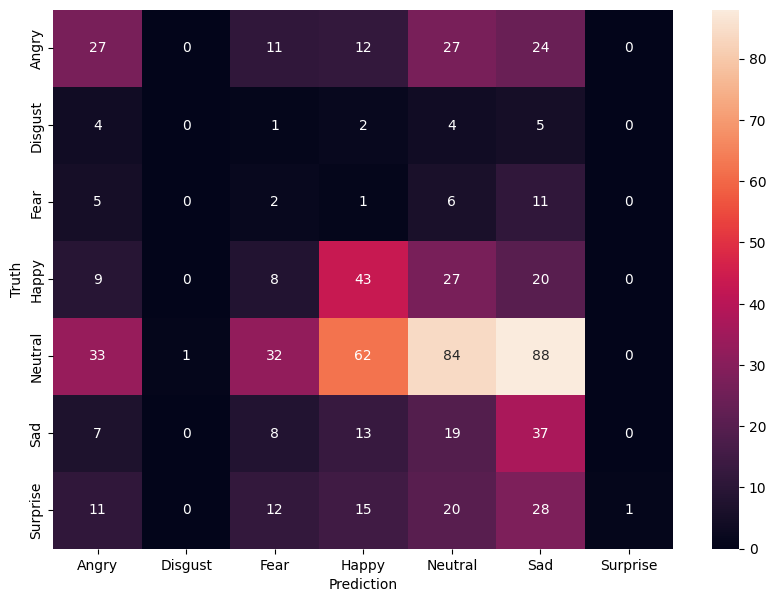

In [100]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')


#**Evaluating SER Model**

In [101]:
src2 = glob.glob('/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/*')

In [102]:
testsrc = src2[:3]

In [111]:
emotion_ser =[]
file_ser = []

for x in src2:
  file_ser.append(x)

  dst = "/content/drive/MyDrive/Emotion_Recognition/wav_files/test0.wav"

  sound = AudioSegment.from_file(x,format="mp4")
  sound.export(dst, format="wav")

  # Sample rate (16.0 kHz)
  sample_rate = 16000

  # Max pad lenght (3.0 sec)
  max_pad_len = 49100

          # Read audio file
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)

          # Z-normalization
  y = zscore(y)

          # Padding or truncated signal
  if len(y) < max_pad_len:
    y_padded = np.zeros(max_pad_len)
    y_padded[:len(y)] = y
    y = y_padded
  elif len(y) > max_pad_len:
    y = np.asarray(y[:max_pad_len])

  # Data Preprocessing
  mel_spect = np.asarray(mel_spectrogram(y))
  mel_spect = np.reshape(mel_spect,(1,128,384))
  input = frame(mel_spect, hop_ts, win_ts)
  input = input.reshape(input.shape[0], input.shape[1] , input.shape[2], input.shape[3], 1)

  for speech in input:
      res = model_ser.predict(input)
      result_num2 = np.argmax(res)
      #print(result_num)
      #print("Emotion from SER:", get_label_ser(result_num2))
      #print("Emotion Probability: ", np.amax(res))
      emotion_ser.append(get_label_ser(result_num2))


1/1 [==============================] - 0s 35ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 38ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 29ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 31ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 29ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 28ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 32ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 48ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 30ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 39ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 46ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 29ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 54ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 45ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 30ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 32ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 29ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 37ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 28ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 35ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 29ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 33ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 34ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 28ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 30ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 35ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 31ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 28ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 31ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 27ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 34ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 41ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 27ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 34ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 35ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 28ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 30ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 38ms/step


<ipython-input-111-3fdabb31608c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 31ms/step


In [116]:
SpeechResults = pd.DataFrame()

In [117]:
SpeechResults["File"] = file_ser
SpeechResults["Speech_Emotion"] = emotion_ser

In [118]:
SpeechResults.head()

,File,Speech_Emotion
0,/content/drive/MyDrive/Emotion_Recognition/Mod...,Surprise
1,/content/drive/MyDrive/Emotion_Recognition/Mod...,Surprise
2,/content/drive/MyDrive/Emotion_Recognition/Mod...,Neutral
3,/content/drive/MyDrive/Emotion_Recognition/Mod...,Happy
4,/content/drive/MyDrive/Emotion_Recognition/Mod...,Surprise


In [115]:
SpeechResults.to_csv('/content/drive/MyDrive/CSV_Results/Speech_Emotion.csv', index=False)

In [119]:
from sklearn.metrics import classification_report
df2 = pd.read_csv("dev_sent_emo.csv")

In [120]:
df2.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,Predicted_Emotion_SER,Predicted_Emotion_Text,Predicted_Emotion_Ensemble
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,Sad,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dia0_utt0.mp4,No Emotion,Happy,NaN,NaN
1,2,What?,Monica,Surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dia0_utt1.mp4,No Emotion,Surprise,NaN,NaN
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,Neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dia1_utt0.mp4,No Emotion,Happy,NaN,NaN
3,4,Youre a genius!,Chandler,Happy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",dia1_utt1.mp4,No Emotion,Surprise,NaN,NaN
4,5,"Aww, man, now we wont be bank buddies!",Joey,Sad,negative,1,2,4,4,"00:12:34,211","00:12:37,505",dia1_utt2.mp4,No Emotion,Happy,NaN,NaN


In [121]:
y_true = df2['True_Emotion']
y_pred = df2['Predicted_Emotion_SER']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.10      0.01      0.01       153
     Disgust       0.00      0.00      0.00        22
        Fear       0.06      0.05      0.06        40
       Happy       0.15      0.36      0.21       163
     Neutral       0.34      0.13      0.19       469
         Sad       0.20      0.03      0.05       111
    Surprise       0.18      0.55      0.27       150

    accuracy                           0.19      1108
   macro avg       0.15      0.16      0.11      1108
weighted avg       0.23      0.19      0.16      1108



In [122]:

labels = np.unique(y_true)
cm2 = confusion_matrix(y_true, y_pred)
cm2 = pd.DataFrame(cm2, index=labels, columns=labels)

Text(95.72222222222221, 0.5, 'Truth')

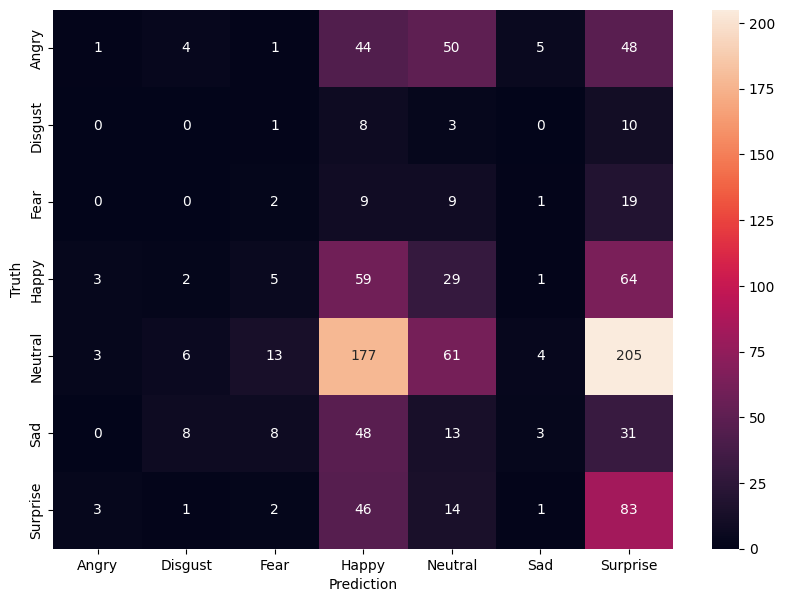

In [124]:
plt.figure(figsize = (10,7))
sn.heatmap(cm2, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

#**Evaluating Text_ER Model**

In [65]:
src3 = glob.glob('/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/*')

In [71]:
df3 = pd.read_csv("dev_sent_emo.csv")

In [72]:
df3.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,Predicted_Emotion_SER,Predicted_Emotion_Text,Predicted_Emotion_Ensemble
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,Sad,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dia0_utt0.mp4,No Emotion,Happy,NaN,NaN
1,2,What?,Monica,Surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dia0_utt1.mp4,No Emotion,Surprise,NaN,NaN
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,Neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dia1_utt0.mp4,No Emotion,Happy,NaN,NaN
3,4,Youre a genius!,Chandler,Happy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",dia1_utt1.mp4,No Emotion,Surprise,NaN,NaN
4,5,"Aww, man, now we wont be bank buddies!",Joey,Sad,negative,1,2,4,4,"00:12:34,211","00:12:37,505",dia1_utt2.mp4,No Emotion,Happy,NaN,NaN


In [80]:
dialogue = df3['Utterance'].tolist()
file_ter = df3['File_Name_Concatenated'].tolist()

In [81]:
type(dialogue)

list

In [90]:
emotion_ter =[]


for i in dialogue:
  emotion_ter.append(text_prediction([i]))





1/1 [==============================] - 0s 43ms/step


In [92]:
TextResults = pd.DataFrame()

In [93]:
TextResults["File"] = file_ter
TextResults["Text_Emotion"] = emotion_ter

In [94]:
TextResults.head()

,File,Text_Emotion
0,dia0_utt0.mp4,Surprise
1,dia0_utt1.mp4,Surprise
2,dia1_utt0.mp4,Neutral
3,dia1_utt1.mp4,Happy
4,dia1_utt2.mp4,Happy


In [95]:
TextResults.to_csv('/content/drive/MyDrive/CSV_Results/Text_Emotion.csv', index=False)

In [96]:
from sklearn.metrics import classification_report
df4 = pd.read_csv("dev_sent_emo.csv")

In [97]:
df4.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,Predicted_Emotion_SER,Predicted_Emotion_Text,Predicted_Emotion_Ensemble
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,Sad,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dia0_utt0.mp4,No Emotion,Happy,Surprise,NaN
1,2,What?,Monica,Surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dia0_utt1.mp4,No Emotion,Surprise,Surprise,NaN
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,Neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dia1_utt0.mp4,No Emotion,Happy,Neutral,NaN
3,4,Youre a genius!,Chandler,Happy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",dia1_utt1.mp4,No Emotion,Surprise,Happy,NaN
4,5,"Aww, man, now we wont be bank buddies!",Joey,Sad,negative,1,2,4,4,"00:12:34,211","00:12:37,505",dia1_utt2.mp4,No Emotion,Happy,Happy,NaN


In [98]:
y_true = df4['True_Emotion']
y_pred = df4['Predicted_Emotion_Text']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.32      0.08      0.13       153
     Disgust       0.07      0.27      0.12        22
        Fear       0.07      0.35      0.11        40
       Happy       0.29      0.75      0.41       163
     Neutral       0.77      0.18      0.30       469
         Sad       0.43      0.05      0.10       111
    Surprise       0.32      0.48      0.39       150

    accuracy                           0.29      1108
   macro avg       0.32      0.31      0.22      1108
weighted avg       0.50      0.29      0.27      1108



In [99]:

labels = np.unique(y_true)
cm3 = confusion_matrix(y_true, y_pred)
cm3 = pd.DataFrame(cm3, index=labels, columns=labels)

Text(95.72222222222221, 0.5, 'Truth')

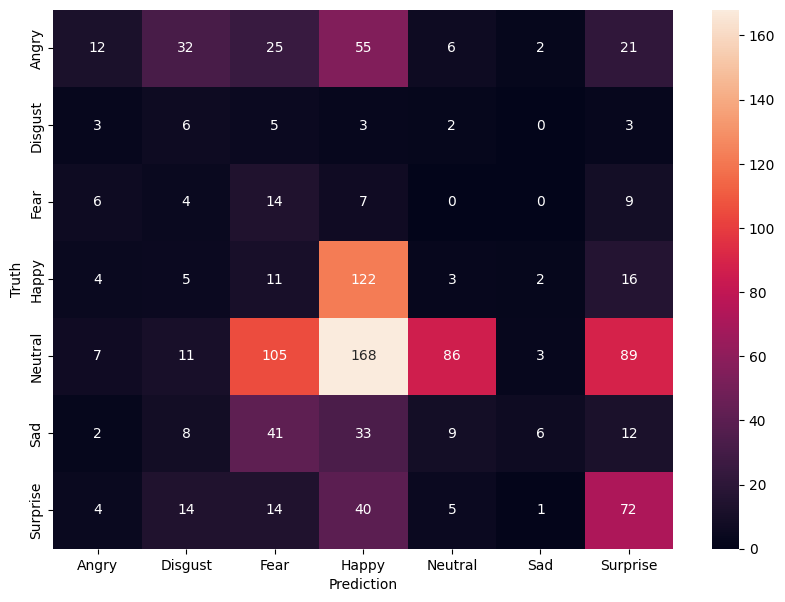

In [101]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm3, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [ ]:
final_emotion = []
final_probability =[]

vidcap = cv2.VideoCapture(src)

sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

emotions = []
emotions_prob = []

source = glob.glob('/content/drive/MyDrive/Emotion_Recognition/FER/Results/*')

for i in source:
  face = cv2.imread(i)
  for face in extract_face_features(detect_face(face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res1 = model_fer.predict(to_predict)
    result_num = np.argmax(res1)
    prob = np.amax(res1)
    emotion_per_frame = get_label_fer(result_num)
    #print (emotion_per_frame)
    emotions.append(emotion_per_frame)
    emotions_prob.append(prob)

#print(emotions)
#print(emotions_prob)
print("Emotion from FER: ", statistics.mode(emotions))
print("Emotion Probability: ", statistics.mean(emotions_prob))

folder_path = '/content/drive/MyDrive/Emotion_Recognition/FER/Results/'

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.jpg'):
            os.remove(os.path.join(root, file))

dst = "/content/drive/MyDrive/Emotion_Recognition/wav_files/test0.wav"

# convert mp4 to wav

sound = AudioSegment.from_file(src,format="mp4")
sound.export(dst, format="wav")

# Sample rate (16.0 kHz)
sample_rate = 16000

# Max pad lenght (3.0 sec)
max_pad_len = 49100

        # Read audio file
y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)

        # Z-normalization
y = zscore(y)

        # Padding or truncated signal
if len(y) < max_pad_len:
  y_padded = np.zeros(max_pad_len)
  y_padded[:len(y)] = y
  y = y_padded
elif len(y) > max_pad_len:
  y = np.asarray(y[:max_pad_len])

# Data Preprocessing
mel_spect = np.asarray(mel_spectrogram(y))
mel_spect = np.reshape(mel_spect,(1,128,384))
input = frame(mel_spect, hop_ts, win_ts)
input = input.reshape(input.shape[0], input.shape[1] , input.shape[2], input.shape[3], 1)

for speech in input:
    res = model_ser.predict(input)
    result_num2 = np.argmax(res)
    #print(result_num)
    print("Emotion from SER:", get_label_ser(result_num2))
    print("Emotion Probability: ", np.amax(res))

r = speech_recognition.Recognizer()

hellow=speech_recognition.AudioFile(dst)
with hellow as source:
    audio = r.record(source)
try:
    s = r.recognize_google(audio)
    #print("Text: "+s)
    print("Emotion from Text: ", text_prediction([s]))
    print("Emotion Probability: ", np.amax(model_ter.predict([s])))
    compile_emotion = [statistics.mode(emotions), get_label_ser(result_num2), text_prediction([s])]
    compile_emotion_prob = [statistics.mean(emotions_prob), np.amax(res), np.amax(model_ter.predict([s]))]
except Exception as e:
    print("Emotion from Text: ", [])
    print("Emotion Probability: ", [])
    compile_emotion = [statistics.mode(emotions), get_label_ser(result_num2), [""]]
    compile_emotion_prob = [statistics.mean(emotions_prob), np.amax(res), np.amax(model_ter.predict([""]))]


if ((compile_emotion[0] != compile_emotion[1]) and (compile_emotion[0] != compile_emotion[2]) and (compile_emotion[1] != compile_emotion[2])):
  idx = compile_emotion_prob.index(max(compile_emotion_prob))
  final_emotion.append(compile_emotion[idx])
  final_probability.append(max(compile_emotion_prob))

else:
  final_emotion.append(statistics.mode(compile_emotion))

if ((compile_emotion[0] == compile_emotion[1]) and (compile_emotion[0] == compile_emotion[2])):
  final_probability.append(statistics.mean(compile_emotion_prob))
elif ((compile_emotion[0] == compile_emotion[1]) and (compile_emotion[0] != compile_emotion[2])) :
  final_probability.append((compile_emotion_prob[0]+compile_emotion_prob[1])/2)
elif ((compile_emotion[0] == compile_emotion[2]) and (compile_emotion[0] != compile_emotion[1])):
  final_probability.append((compile_emotion_prob[0]+compile_emotion_prob[2])/2)
elif ((compile_emotion[1] == compile_emotion[2]) and (compile_emotion[0] != compile_emotion[1])):
  final_probability.append((compile_emotion_prob[1]+compile_emotion_prob[2])/2)

print("Final Emotion: ", final_emotion)
print("Final Emotion Probability: ", final_probability)

1/1 [==============================] - 0s 56ms/step


<ipython-input-9-62d6636c3fdd>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
<ipython-input-9-62d6636c3fdd>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

1/1 [==============================] - 0s 85ms/step
Emotion from FER:  Angry
Emotion Probability:  0.8369248
1/1 [==============================] - 0s 216ms/step
Emotion from SER: Neutral
Emotion Probability:  0.8652872
1/1 [==============================] - 1s 784ms/step
Emotion from Text:  Neutral
1/1 [==============================] - 1s 596ms/step
Emotion Probability:  0.36786416
1/1 [==============================] - 1s 564ms/step
Final Emotion:  ['Neutral']
Final Emotion Probability:  [0.6165756583213806]
